In [38]:
%pylab inline

import pandas as pd
import pickle
import matplotlib.dates as md
import statsmodels.api as sm
import scipy.stats as dists

from scipy.optimize import minimize

tableau = pickle.load(open('tableau.colors', 'rb'))

rcParams['figure.figsize'] = (10,8)
rcParams['axes.grid'] = True
rcParams['lines.linewidth'] = 2.5
rcParams['axes.prop_cycle'] = cycler('color', tableau)

xfmt = md.DateFormatter('%H:%M:%S')

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('~/Downloads/coinbaseUSD.csv', header=0, names=['t', 'px', 'sz'])
df.t *= 1e9
df.t = pd.to_datetime(df.t)
df['pxd'] = df.px - df.px.shift(1)

# Eliminate early data with insufficient liquidity.
df = df.loc[df.t > "2015-09-03"]

In [166]:
def front(df, stamp, days=1):
    sliced = df.loc[(df.t - pd.to_datetime(stamp)) > pd.Timedelta(days=0)]
    sliced = sliced.loc[(sliced.t - pd.to_datetime(stamp)) < pd.Timedelta(days=days)]
    return sliced

def around(df, stamp, size):
    sliced = df.loc[abs(df.t - pd.to_datetime(stamp)) < pd.Timedelta(days=size/24.)]
    return sliced

def vwap(df, window):
    return (df.px * df.sz).rolling(window).sum() / df.sz.rolling(window).sum()

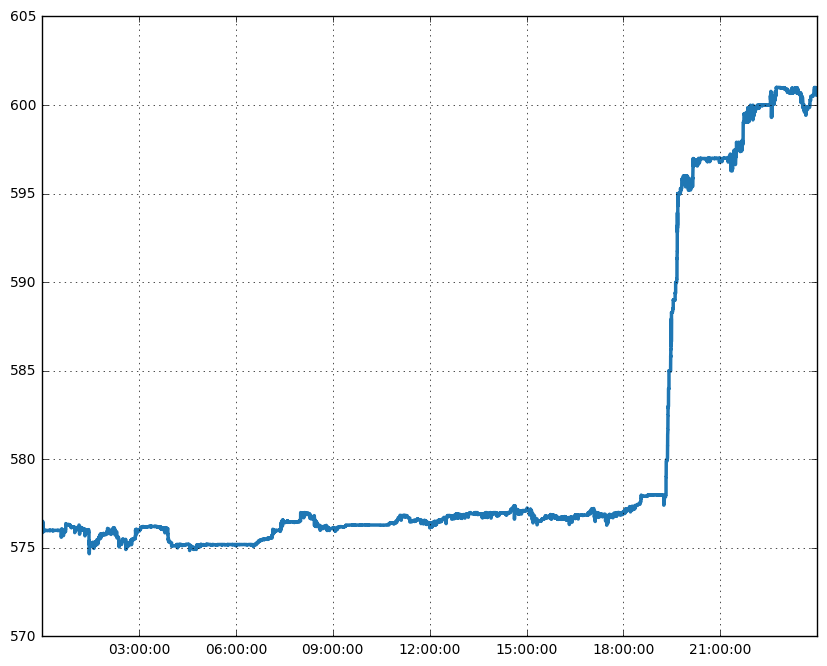

In [167]:
third = front(df, '2016-09-03')
plot(third.t, third.px)

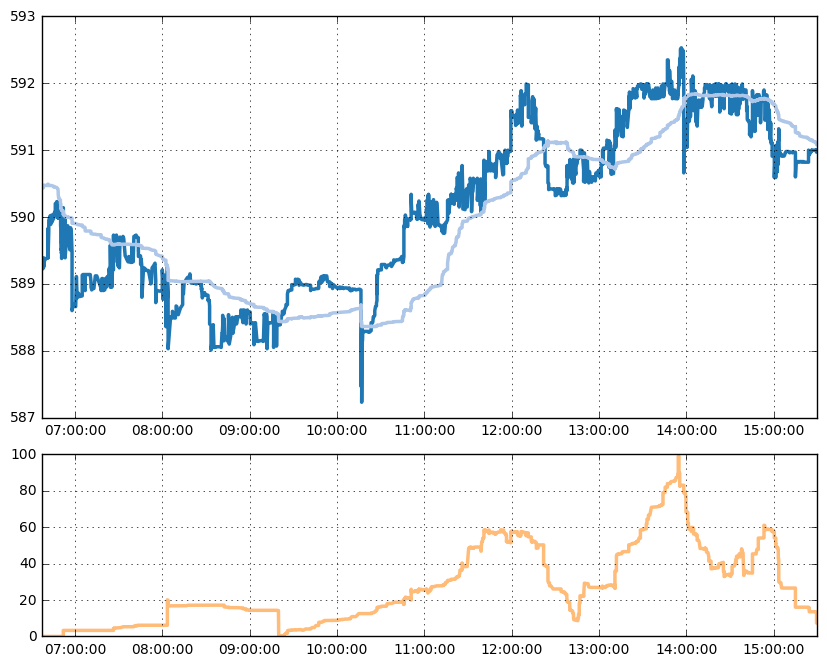

In [5]:
data = around(df, '2016-08-09 10:30:00', 5)

ax = []
ax.append(subplot2grid((3,1),(0,0), rowspan=2))
ax.append(subplot2grid((3,1),(2,0)))

n = 500
signal = (((data.px > vwap(data, n)) & (data.pxd > 0))*data.sz).rolling(n).sum()

ax[0].plot(data.t[n:], data.px[n:])
ax[0].plot(data.t[n:], vwap(data, n)[n:])
ax[1].plot(data.t[n:], signal[n:], c=tableau[3])

ax[0].xaxis.set_major_formatter(xfmt)
ax[1].xaxis.set_major_formatter(xfmt)

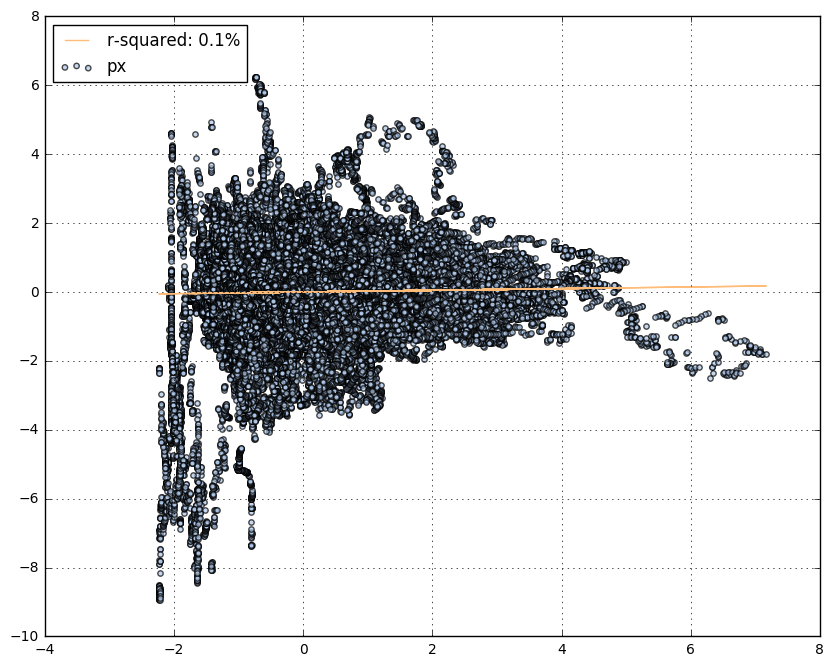

In [7]:
data = front(df, '2016-05-01', days=7)

n = 1000; m = 500

uptick = data.pxd > 0
dntick = data.pxd < 0
upmean = (uptick*data.pxd).rolling(n).sum() / uptick.rolling(n).sum()
dnmean = (dntick*data.pxd).rolling(n).sum() / dntick.rolling(n).sum()

A = (-1. * upmean / dnmean)[n:-m]
B = (data.px.shift(-m) - data.px)[n:-m]

A = (A - A.mean()) / A.std()
B = (B - B.mean()) / B.std()

scatter(A, B, s=15, alpha=0.7, c=tableau[1])
fitted = sm.OLS(B, A).fit()
plot(A, fitted.params[0]*A, lw=1, c=tableau[3],
     label='r-squared: %0.1f%%' % (100.*fitted.rsquared))
legend(loc='upper left')

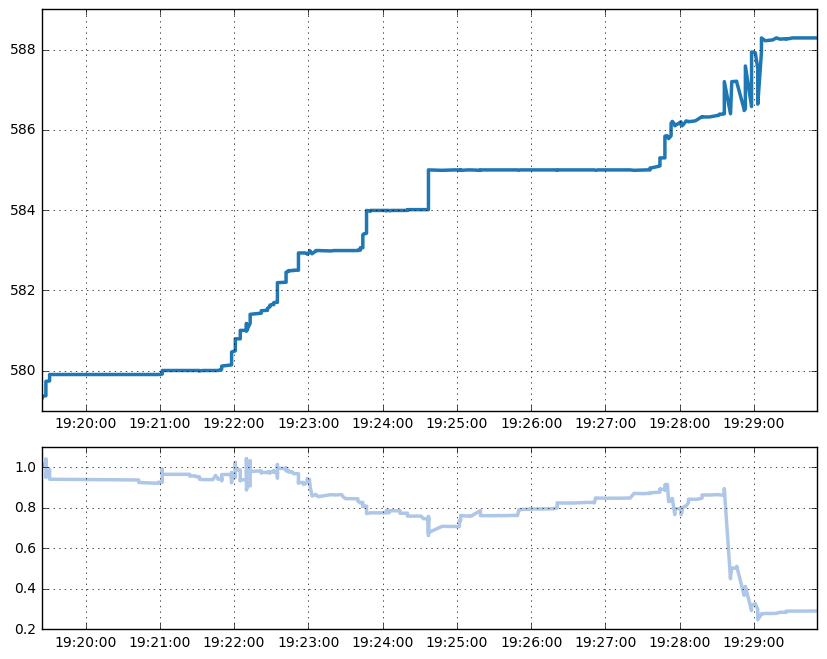

In [8]:
data = around(df, '2016-09-03 18:30:00', 1)

ax = []
ax.append(subplot2grid((3,1),(0,0), rowspan=2))
ax.append(subplot2grid((3,1),(2,0)))

n=1000
uptick = data.pxd > 0
dntick = data.pxd < 0
upvwap = (uptick*data.px*data.sz).rolling(n).sum() / (uptick*data.sz).rolling(n).sum()
dnvwap = (dntick*data.px*data.sz).rolling(n).sum() / (dntick*data.sz).rolling(n).sum()

upmean = (uptick*data.pxd).rolling(n).sum() / uptick.rolling(n).sum()
dnmean = (dntick*data.pxd).rolling(n).sum() / dntick.rolling(n).sum()
upsize = (uptick*data.sz).rolling(n).sum()
dnsize = (dntick*data.sz).rolling(n).sum()

ax[0].plot(data.t[n:], data.px[n:])
ax[1].plot(data.t[n:], (-1. * upmean / dnmean)[n:], c=tableau[1])

ax[0].xaxis.set_major_formatter(xfmt)
ax[1].xaxis.set_major_formatter(xfmt)

In [158]:
# Glosten-Milgrom Model

In [213]:
def saw_buy(prob, price, alpha, eta):
    newprob = prob.copy()
    idx = int(100*price + 4*sigma - v0) 
    # V_i > p_a
    newprob[idx+1:] *= (1 - alpha)*eta + alpha  
    # V_i <= p_a
    newprob[:idx+1] *= 1 - alpha - (1 - alpha)*eta  
    return newprob/newprob.sum()

def saw_sell(prob, price, alpha, eta):
    newprob = prob.copy()
    idx = int(100*price + 4*sigma - v0) 
    # V_i < p_b
    newprob[:idx] *= (1 - alpha)*eta + alpha      
    # V_i >= p_b
    newprob[idx:] *= 1 - alpha - (1 - alpha)*eta  
    return newprob/newprob.sum()

def learn(row, prob0, alpha, eta):
    prob = prob0.copy()
    if row.pxd > 0:
        prob = saw_buy(prob, row.px, alpha, eta)
    elif row.pxd < 0:
        prob = saw_sell(prob, row.px, alpha, eta)
    return prob

def compute(data, vals, prob, n, alpha, eta):
    bests = ndarray(n+1)
    probs = ndarray((n+1, len(prob)))
    probs[0] = prob.copy()
    bests[0] = (vals*probs[0]).sum()
    for i in range(1,n+1):
        probs[i] = learn(data.iloc[i], probs[i-1], alpha, eta)
        bests[i] = (vals*probs[i]).sum()
    return bests, probs

def estimate(data, params):
    sigma = params[0]
    alpha = params[1]
    eta = params[2]
    
    v0 = 100 * (data.iloc[0].px)
    sigma = (v0 * sigma)*sqrt((data.iloc[-1].t - data.iloc[0].t).total_seconds() / (60*60*24))
    prob = ndarray(int(8*sigma) + 1)
    vals = (v0 - 4*sigma + arange(len(prob)))/100
    for i in range(len(prob)):
        prob[i] = dists.norm.pdf(v0 - 4*sigma + i, loc=v0, scale=sigma)
   
    bests, probs = compute(data, vals, prob, len(data)-1, alpha, eta)
    
    ests = pd.DataFrame(columns=['t','a','e'])
    ests.t = data.t 
    ests.a = data.px.shift(1)
    ests.e = bests
    ests = ests.iloc[1:]
    return ests

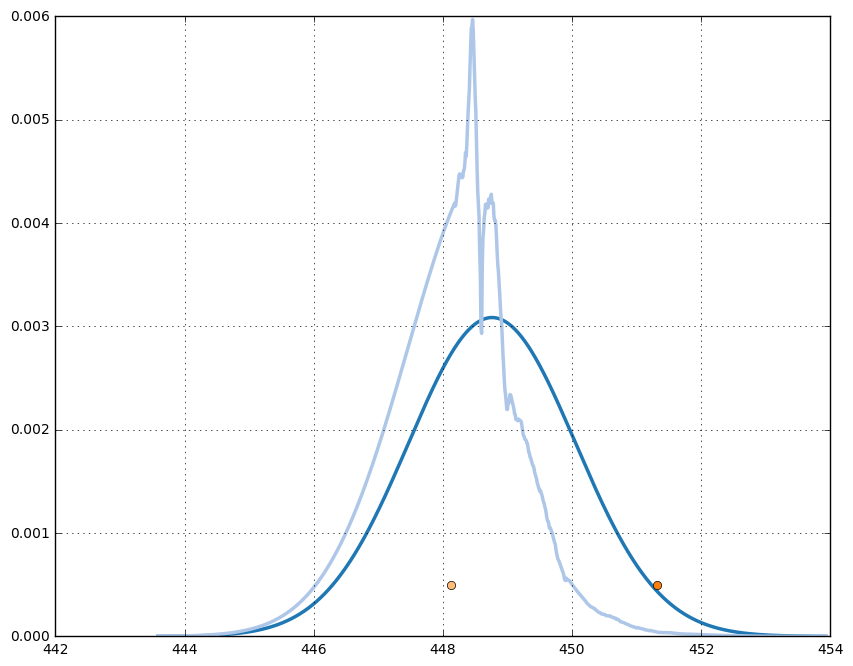

In [210]:
data = around(df, '2016-05-03 18:30:00', 1)

v0 = 100 * (data.iloc[0].px)
sigma = (v0 * 0.01)*sqrt((data.iloc[-1].t - data.iloc[0].t).total_seconds() / (60*60*24))
prob = ndarray(int(8*sigma) + 1)
vals = (v0 - 4*sigma + arange(len(prob)))/100
for i in range(len(prob)):
    prob[i] = dists.norm.pdf(v0 - 4*sigma + i, loc=v0, scale=sigma)

plot(vals, prob)

bests, probs = compute(data, vals, prob, len(data)-1, 0.005, 0.5)
plot(vals, probs[-1])
plot(data.iloc[-1].px, 0.0005, 'o')
plot((vals*probs[-1]).sum(), 0.0005, 'o')

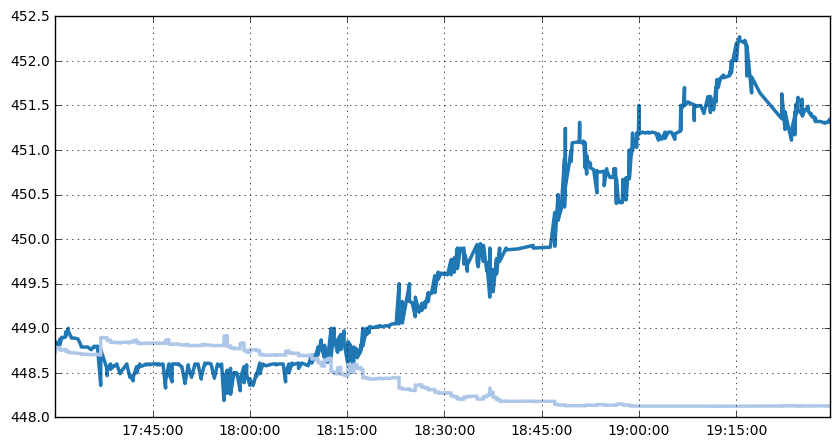

In [193]:
ax = []
ax.append(subplot2grid((3,1),(0,0), rowspan=2))

ax[0].plot(data.t, data.px)
ax[0].plot(data.t, bests)

ax[0].xaxis.set_major_formatter(xfmt)

In [214]:
data = around(df, '2016-05-03 18:30:00', 1)

def obj(params):
    ests = estimate(data, params)
    return ((ests.a - ests.e)**2).sum()

cons = [{'type': 'ineq', 'fun': lambda params: -params[0]},
        {'type': 'ineq', 'fun': lambda params: params[1] - 1},
        {'type': 'ineq', 'fun': lambda params: -params[1]},
        {'type': 'ineq', 'fun': lambda params: params[2] - 1},
        {'type': 'ineq', 'fun': lambda params: -params[2]}]
minimize(obj, [0.05, 0.05, 0.50], constraints=cons)

ValueError: negative dimensions are not allowed